In [1]:
import glob
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

In [2]:
#Zipline Data Challenge: An Exploratory Analysis
#Conner Reinhardt

# Get data file names
path ='/Users/connerreinhardt/Google Drive/EVERYTHING ELSE (PRE-2020)/data_scientist_take-home'
filenames = glob.glob(path + "/*.csv")
flightfiles = filenames[:-1]
summaryfile = path + "/summary_data.csv"

flight_summary = pd.read_csv(summaryfile)

# Gather all detailed flight data and classify them
dfs = []
for flightfile in flightfiles:
    addflight = pd.read_csv(flightfile)
    addflight['flight_number'] = flightfile[-9:-4]
    dfs.append(addflight)
    
# Concatenate all detail flight data into one DataFrame
flight_detail = pd.concat(dfs, ignore_index=True)
    #print(big_frame[big_frame['flight_number']=='16962'])

# Create summary file DataFrame

<AxesSubplot:>

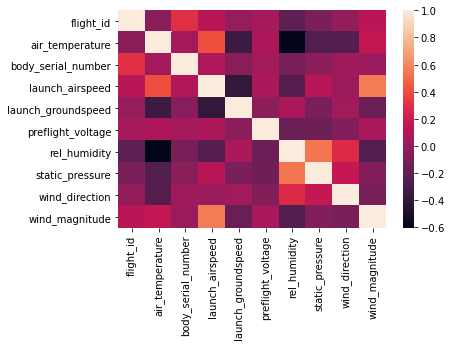

In [3]:
%matplotlib inline
# calculate the correlation matrix
corr = flight_summary.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)


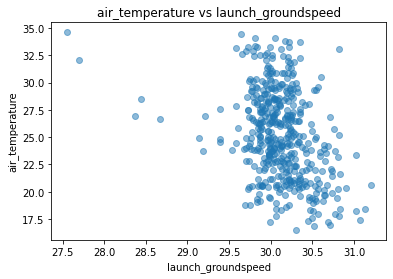

LinregressResult(slope=-3.8242990766627374, intercept=140.39265429804755, rvalue=-0.3480498367348779, pvalue=3.5593209358006056e-14, stderr=0.4883043375076806, intercept_stderr=14.705022425064694)


In [4]:
from scipy import stats
# In the above we see a noteable negative correlations between launch_groundspeed and air_temperature
# Let's start out exploratory analysis but observing this correlation
plt.scatter(flight_summary['launch_groundspeed'], flight_summary['air_temperature'], alpha=0.5)
plt.title('air_temperature vs launch_groundspeed')
plt.xlabel('launch_groundspeed')
plt.ylabel('air_temperature')
plt.show()

modeloutput = stats.linregress(flight_summary['launch_groundspeed'],flight_summary['air_temperature'])
print(modeloutput)

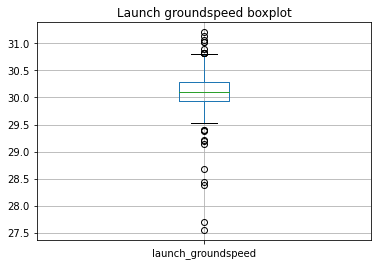

count    447.000000
mean      30.112178
std        0.371296
min       27.548899
25%       29.926867
50%       30.097641
75%       30.282600
max       31.205293
Name: launch_groundspeed, dtype: float64


In [5]:
# in the plot above we can see how the negative correlation may exist between these variables is contigent 
# on a small subset of flights that appear to have super low groundspeed
flight_summary.boxplot(column='launch_groundspeed')
plt.title('Launch groundspeed boxplot')
plt.show()
print(flight_summary['launch_groundspeed'].describe())

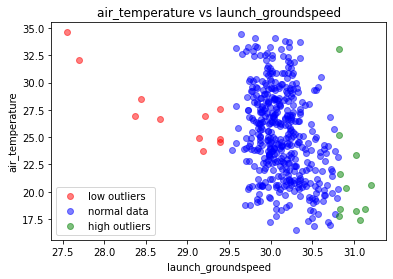

In [6]:
# From above we see an IQR of 0.356, so 1.5*IQR + 75th quantile is 30.816 and 25th quantile - 1.5*IQR is 29.393
# We can visualize these outlier data points below in red on the scatterplot and it becomes very apparent that there
# are only a few outlier flights that lead us to see a negative correlation between air_temperature and ground speed

lowgroundspeed = flight_summary[flight_summary['launch_groundspeed']<=29.5]
normalgroundspeed = flight_summary[(flight_summary['launch_groundspeed']>29.393)
                                   &(flight_summary['launch_groundspeed']<=30.816)]
highgroundspeed = flight_summary[flight_summary['launch_groundspeed']>30.816]

plt.scatter(lowgroundspeed['launch_groundspeed'], lowgroundspeed['air_temperature'], color='red', alpha=0.5)
plt.scatter(normalgroundspeed['launch_groundspeed'], normalgroundspeed['air_temperature'], color='blue', alpha=0.5)
plt.scatter(highgroundspeed['launch_groundspeed'], highgroundspeed['air_temperature'], color='green', alpha=0.5)
plt.title('air_temperature vs launch_groundspeed')
plt.xlabel('launch_groundspeed')
plt.ylabel('air_temperature')
plt.gca().legend(('low outliers','normal data','high outliers'))
plt.show()

In [7]:
# Now we'll look into the flight detail files that provide more context for each of the flights examined above
# Since we're examining ground speed in the summary file, and the flight details show speed in the X,Y, and Z directions
# seperately, we'll need to create a ground speed variable from these details so that we can compare to the
# scatterplot on a one for one basis-- 
# Here we use pythagoreans principle to turn the vector data into scalars independent of direction 
# (ground coordinates only) - "velocity_ground_mps"
flight_detail['velocity_ground_mps'] = np.sqrt((flight_detail['velocity_ned_mps[0]'])**2 
                                           + (flight_detail['velocity_ned_mps[1]'])**2)

#for col in flight_detail.columns:
    #print(col)

In [8]:
# Printing out the red points in the scatterplot,
# We can see that there are 11 flights that are outliers with low groundspeed
print(lowgroundspeed[['flight_id','launch_groundspeed']])

    flight_id  launch_groundspeed
29      17016           29.133639
30      17019           29.392909
31      17020           29.391953
32      17022           29.190197
82      17122           29.387475
83      17123           29.209283
84      17124           28.375102
85      17125           28.670392
86      17126           28.441710
87      17128           27.548899
88      17130           27.692286


In [9]:
# And if we want to look at the flight with the median groundspeed we realize its flight 17151
print(flight_summary[flight_summary['launch_groundspeed']==30.09764148541062])

     flight_id  air_temperature battery_serial_number  body_serial_number  \
100      17151            29.65       15SPJJJ10022048  577350132807348254   

         commit  launch_airspeed  launch_groundspeed         launch_timestamp  \
100  5c504d9a16        33.814453           30.097641  2018-09-12 12:01:31 CAT   

     preflight_voltage  rel_humidity  static_pressure  wind_direction  \
100          32.193016     60.474992      80474.68524      -39.403119   

     wind_magnitude wing_serial_number  
100        3.222529    15SPJJJ09052035  


In [10]:
# Let's examine one of flights, 17130, which has the lowest groundspeed of them all
flight17130 = flight_detail[flight_detail['flight_number']=='17130']
# We can compare it to flight 17151, which has the median "normal" groundspeed as a control
flight17151 = flight_detail[flight_detail['flight_number']=='17151']

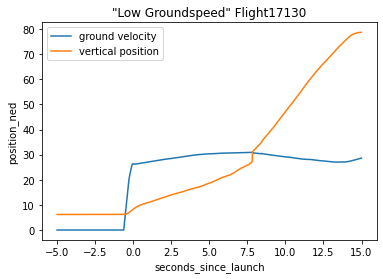

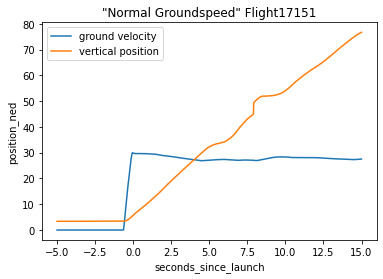

In [11]:
#Below we will plot both flights' groundspeeds against their vertical ascent to try to uncover the differences
plt.plot(flight17130['seconds_since_launch'], flight17130['velocity_ground_mps'],
         flight17130['seconds_since_launch'], -flight17130['position_ned_m[2]'])
plt.gca().legend(('ground velocity','vertical position'))
plt.title('"Low Groundspeed" Flight17130')
plt.xlabel('seconds_since_launch')
plt.ylabel('position_ned')
plt.show()

plt.plot(flight17151['seconds_since_launch'], flight17151['velocity_ground_mps'],
         flight17151['seconds_since_launch'], -flight17151['position_ned_m[2]'])
plt.gca().legend(('ground velocity','vertical position'))
plt.title('"Normal Groundspeed" Flight17151')
plt.xlabel('seconds_since_launch')
plt.ylabel('position_ned')
plt.show()

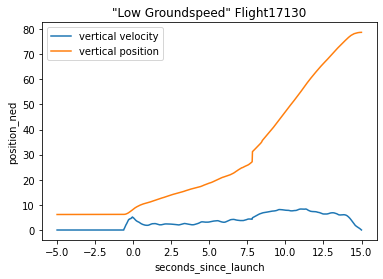

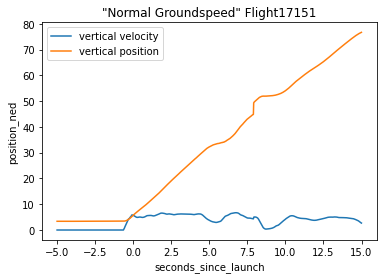

In [12]:
# interestingly we see above two strange occurences @ 7.5s mark
# the normal flight appeared to take off in a mostly uniform ascent, with a blip where the altitude jumped up
# and the low groundspeed flight seemingly also jumped at a point, going from a slow ascent to a much faster one
# to examine the different jumps in the elevation above, lets repear the graphs and see if their vertcal
# airspeeds match these jumps in elevation
plt.plot(flight17130['seconds_since_launch'], -flight17130['velocity_ned_mps[2]'],
         flight17130['seconds_since_launch'], -flight17130['position_ned_m[2]'])
plt.gca().legend(('vertical velocity','vertical position'))
plt.title('"Low Groundspeed" Flight17130')
plt.xlabel('seconds_since_launch')
plt.ylabel('position_ned')
plt.show()

plt.plot(flight17151['seconds_since_launch'], -flight17151['velocity_ned_mps[2]'],
         flight17151['seconds_since_launch'], -flight17151['position_ned_m[2]'])
plt.gca().legend(('vertical velocity','vertical position'))
plt.title('"Normal Groundspeed" Flight17151')
plt.xlabel('seconds_since_launch')
plt.ylabel('position_ned')
plt.show()

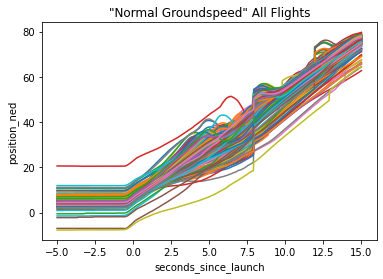

In [13]:
# though we would expect to see a super high vertical velocity for both flights around the 7.5s mark
# we end up not seeing a velocity that corresponds to the change in altitude
# this indicates that the altitude change may in fact be due to bad data
# in order to verify this claim, lets first plot all of the data for vertical position of every flight and overlay it
flight_numbers = flight_summary['flight_id']
for flight in flight_numbers:
    currentflight = flight_detail[flight_detail['flight_number']==str(flight)]
    plt.plot(currentflight['seconds_since_launch'], -currentflight['position_ned_m[2]'])
plt.title('"Normal Groundspeed" All Flights')
plt.xlabel('seconds_since_launch')
plt.ylabel('position_ned')
plt.show()

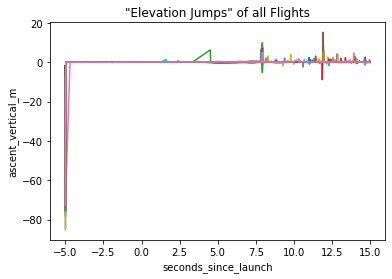

In [14]:
# what we see in the above chart is a very clear pattern of questionable elevation data around the 7.5s mark
# we also see some questionable jumps around what appears to be 12s, 12.5s, and 13s, though these are not nearly common
# To investigate, lets create a column that details the difference in postition between two consecutive sensor readings
# "ascent_vertical_m"
flight_detail['ascent_vertical_m'] = -flight_detail['position_ned_m[2]'].diff()
# NOTE -- .diff() finds the value change from one row to the next -- in this case the elevation change between readings
# print(flight_detail.head())
for flight in flight_numbers:
    currentflight = flight_detail[flight_detail['flight_number']==str(flight)]
    plt.plot(currentflight['seconds_since_launch'], currentflight['ascent_vertical_m'])
plt.title('"Elevation Jumps" of all Flights')
plt.xlabel('seconds_since_launch')
plt.ylabel('ascent_vertical_m')
plt.show()

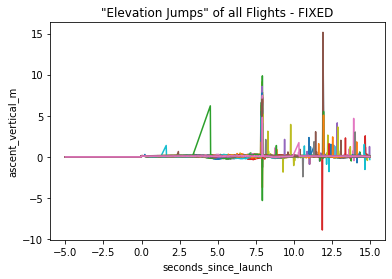

In [15]:
# NOTE: because of the way the dataframe concats all flights, we see a massive difference at the -5s mark since we
# jump from one flight to a new one
# below we will get rid of this
flight_detail.loc[flight_detail['seconds_since_launch']<0, 'ascent_vertical_m'] = 0
for flight in flight_numbers:
    currentflight = flight_detail[flight_detail['flight_number']==str(flight)]
    plt.plot(currentflight['seconds_since_launch'], currentflight['ascent_vertical_m'])
plt.title('"Elevation Jumps" of all Flights - FIXED')
plt.xlabel('seconds_since_launch')
plt.ylabel('ascent_vertical_m')
plt.show()

count    446275.000000
mean          0.069629
std           0.168666
min          -8.897973
25%           0.000000
50%           0.082790
75%           0.101781
max          15.159457
Name: ascent_vertical_m, dtype: float64


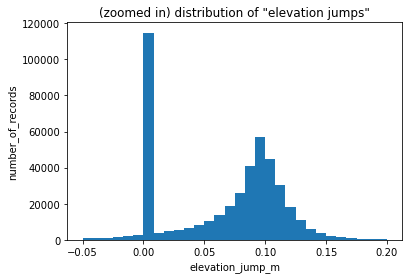

In [16]:
# Now that all that's left is true elevation difference data, we should analyze the distribution of the "elevation jumps"
# which jumps are normal and which may indicate bad data?
# remember that a "jump" in this case is the elevation change between two sensor readings -- this should be small
print(flight_detail['ascent_vertical_m'].describe())
plt.hist(flight_detail['ascent_vertical_m'], bins=30, range=(-.05,.2))
plt.title('(zoomed in) distribution of "elevation jumps"')
plt.xlabel('elevation_jump_m')
plt.ylabel('number_of_records')
plt.show()

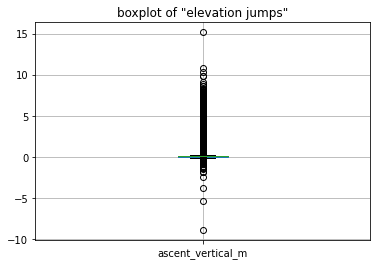

In [17]:
# above we see the summary statistics and the distribution of various jumps in elevation appear to be normally
# distributed around a mean of 0.069m between readings (with 0 as an obvious spike for when the drone has not taken off)
flight_detail.boxplot(column='ascent_vertical_m')
plt.title('boxplot of "elevation jumps"')
plt.show()

count    1037.000000
mean        7.725136
std         1.844968
min         0.219940
25%         7.117710
50%         7.897620
75%         7.937570
max        14.995430
Name: seconds_since_launch, dtype: float64


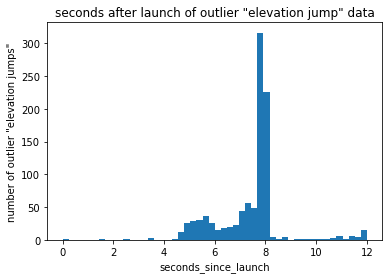

In [18]:
# when we do a boxplot, however, we quickly see that there are some VERY apparent outliers that extend WAY beyond
# the 1.5*IQR (0.152m) above and below the 25/75th (0/0.101) percentiles
# anything above 0.253m or below -0.152m would be technically considered an outlier (or non-plausible value in this case)
# below we will identify the outlier readings per flight based on these definitions and explore WHEN they occur

# define if the ascent data is an outlier or not
flight_detail['outlier_ascent'] = (flight_detail['ascent_vertical_m']>0.253)|(flight_detail['ascent_vertical_m']<-0.152)
outlierdata = flight_detail[flight_detail['outlier_ascent']]

print(outlierdata['seconds_since_launch'].describe())
plt.hist(outlierdata['seconds_since_launch'], bins=50, range=(0,12))
plt.title('seconds after launch of outlier "elevation jump" data')
plt.xlabel('seconds_since_launch')
plt.ylabel('number of outlier "elevation jumps"')
plt.show()


0    7.91759
1    7.93756
dtype: float64


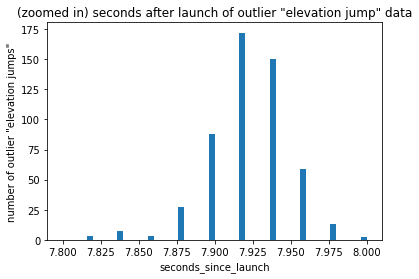

In [19]:
# And if we zoom in more we can see that the data is generally quite focused around a single time interval
print(outlierdata['seconds_since_launch'].mode())
plt.hist(outlierdata['seconds_since_launch'], bins=50, range=(7.8,8))
plt.title('(zoomed in) seconds after launch of outlier "elevation jump" data')
plt.xlabel('seconds_since_launch')
plt.ylabel('number of outlier "elevation jumps"')
plt.show()

In [20]:
# We see that over half of the outlier data lies between 7.8s and 8s into the flight, so lets assume that these are
# due to a similar equipment malfunction and classify outliers accordingly
print("Total elevation jump outliers:",len(outlierdata['seconds_since_launch']))
print("Elevation jump outliers in 7.8s-8s interval:",len(outlierdata[outlierdata['seconds_since_launch']<=8])
     -len(outlierdata[outlierdata['seconds_since_launch']<=7.8]))

# We can isolate outlier readings ONLY during this interval
flight_detail['outlier_ascent_interval'] = ((flight_detail['outlier_ascent'])&
                                            (flight_detail['seconds_since_launch']<=8)
                                            &(flight_detail['seconds_since_launch']>=7.8))


Total elevation jump outliers: 1037
Elevation jump outliers in 7.8s-8s interval: 524


In [21]:
# lets now take the intraflight outlier data and summarize it on a per-flight scale (for the summary data)
# number of outliers within interval and in total, as well as the avg magnitude of outliers in interval (in meters)
flight_summary['outlier_inside_interval'] = 0
flight_summary['outlier_total'] = 0
flight_summary['altitude_at_7.8s'] = 0

for flight in flight_numbers:
    # classifying an elevation jump as an outlier in 7.8s to 8s interval
    intervaloutliers = flight_detail[(flight_detail['flight_number']==str(flight))
                                 &(flight_detail['outlier_ascent_interval'])]
    totaloutliers = flight_detail[(flight_detail['flight_number']==str(flight))
                                 &(flight_detail['outlier_ascent'])]
    
    # find the altitude right before the interval
    preintalt = flight_detail[(flight_detail['flight_number']==str(flight))&
                              (flight_detail['seconds_since_launch']>7.5)&(flight_detail['seconds_since_launch']<7.8)]
  
    flight_summary.loc[flight_summary['flight_id']==flight, 'altitude_at_7.8s'] = -preintalt['position_ned_m[2]'].mean()
    
    # assigning the count of the total number of outliers (both within 7.8-8s interval and in total)
    flight_summary.loc[flight_summary['flight_id']==flight, 'outlier_inside_interval'] = len(intervaloutliers)
    flight_summary.loc[flight_summary['flight_id']==flight, 'outlier_inside_interval_avg'] = intervaloutliers['ascent_vertical_m'].mean()
    flight_summary.loc[flight_summary['flight_id']==flight, 'outlier_total'] = len(totaloutliers)
#     print('flight',flight,"has ",len(intervaloutliers),intervaloutliers['ascent_vertical_m'].mean(), 
#           "from 7.8 to 8s and", len(totaloutliers), "total")

    

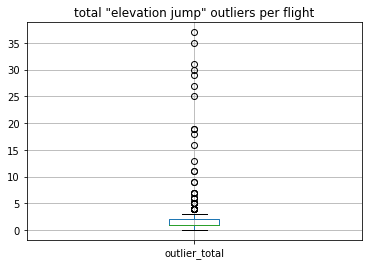

count    447.000000
mean       2.319911
std        4.171560
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       37.000000
Name: outlier_total, dtype: float64


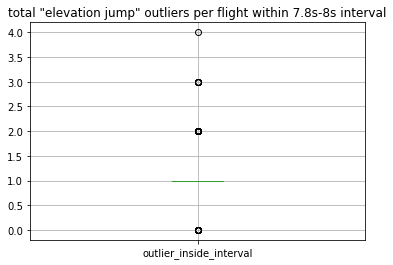

count    447.000000
mean       1.172260
std        0.482278
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: outlier_inside_interval, dtype: float64


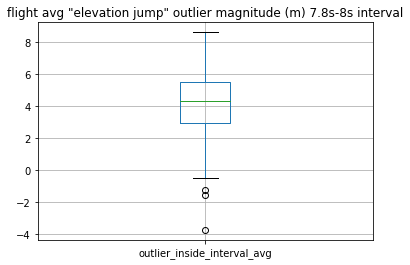

count    436.000000
mean       4.204732
std        1.879657
min       -3.729357
25%        2.964137
50%        4.347992
75%        5.521340
max        8.624320
Name: outlier_inside_interval_avg, dtype: float64


In [22]:
# Next we can visualize on a summarize per flight basis what the flight-by-flight number of outliers is within
# 7.8-8s interval and in total (across any moment of the flight)

flight_summary.boxplot(column='outlier_total')
plt.title('total "elevation jump" outliers per flight')
plt.show()
print(flight_summary['outlier_total'].describe())

flight_summary.boxplot(column='outlier_inside_interval')
plt.title('total "elevation jump" outliers per flight within 7.8s-8s interval')
plt.show()
print(flight_summary['outlier_inside_interval'].describe())

flight_summary.boxplot(column='outlier_inside_interval_avg')
plt.title('flight avg "elevation jump" outlier magnitude (m) 7.8s-8s interval')
plt.show()
print(flight_summary['outlier_inside_interval_avg'].describe())

In [23]:
# Let's conservatively classify a "good flight" as one with no outliers at all
flight_summary['good_flight'] = flight_summary['outlier_total']==0

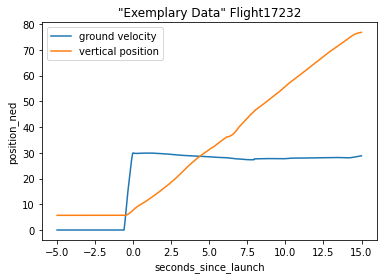

     flight_id  air_temperature battery_serial_number  body_serial_number  \
142      17232             23.4       15SPJJJ10050016  577350132807348254   

         commit  launch_airspeed  launch_groundspeed         launch_timestamp  \
142  5c504d9a16         31.68824           30.220672  2018-09-16 08:53:19 CAT   

     preflight_voltage  rel_humidity  static_pressure  wind_direction  \
142          32.127113      58.02499     80618.943309       -0.817061   

     wind_magnitude wing_serial_number  outlier_inside_interval  \
142        1.184406    15SPJJJ09008034                        0   

     outlier_total  altitude_at_7.8s  outlier_inside_interval_avg  good_flight  
142              0         44.446964                          NaN         True  


In [24]:
# As it turns out there is only one flight with no elevation outliers (17232), and it does appear to be good
flight17232 = flight_detail[flight_detail['flight_number']=='17232']
plt.plot(flight17232['seconds_since_launch'], flight17232['velocity_ground_mps'],
         flight17232['seconds_since_launch'], -flight17232['position_ned_m[2]'])
plt.gca().legend(('ground velocity','vertical position'))
plt.title('"Exemplary Data" Flight17232')
plt.xlabel('seconds_since_launch')
plt.ylabel('position_ned')
plt.show()
print(flight_summary[flight_summary['flight_id']==17232])

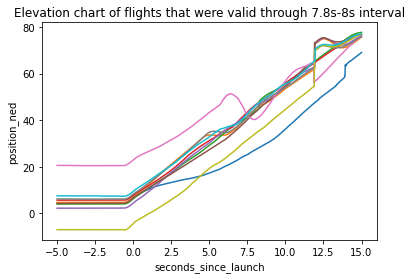

In [25]:
# Note that our exemplary flight took off with low wind on a high pressure day with high groundspeed

# If we relax our definition slightly to only ensure that there are no outliers in the 7.8-8s interval
# we are left with 10 flights, but as you can see they all contain noticeable glitches (just not within the interval)
flight_summary['good_flight_interval'] = flight_summary['outlier_inside_interval']==0

# We can graph all flights with one or fewer outliers
flight_summary_good = flight_summary[flight_summary['good_flight_interval']]
good_flight_numbers = flight_summary_good['flight_id']
for flight in good_flight_numbers:
    currentflight = flight_detail[flight_detail['flight_number']==str(flight)]
    plt.plot(currentflight['seconds_since_launch'], -currentflight['position_ned_m[2]'])
    
plt.title('Elevation chart of flights that were valid through 7.8s-8s interval')
plt.xlabel('seconds_since_launch')
plt.ylabel('position_ned')
plt.show()

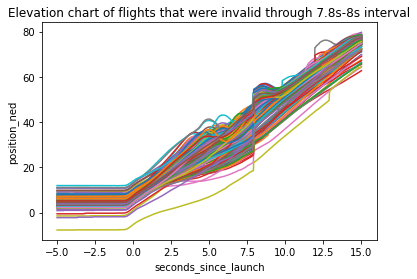

In [26]:
# Then relaxing even more to include all 436 other flights with noticeable elevation glitches between 7.8s-8s
flight_summary['bad_flight_interval'] = flight_summary['outlier_inside_interval']>0

# We can graph all flights with one or fewer outliers
flight_summary_bad = flight_summary[flight_summary['bad_flight_interval']]
bad_flight_numbers = flight_summary_bad['flight_id']
for flight in bad_flight_numbers:
    currentflight = flight_detail[flight_detail['flight_number']==str(flight)]
    plt.plot(currentflight['seconds_since_launch'], -currentflight['position_ned_m[2]'])
    
plt.title('Elevation chart of flights that were invalid through 7.8s-8s interval')
plt.xlabel('seconds_since_launch')
plt.ylabel('position_ned')
plt.show()

In [27]:
# Given that these bad flights make up 97.5% of the total flights, we can quantify the average outlier magnitude
# ("elevation jump") during this 7.8s-8s time window and see what correlates highly to it

corrintavg = flight_summary.corr()['outlier_inside_interval_avg']
print("Correlations to increased outlier magnitude during 7.8s-8s interval:")
print(corrintavg)

Correlations to increased outlier magnitude during 7.8s-8s interval:
flight_id                     -0.079008
air_temperature                0.157579
body_serial_number             0.047399
launch_airspeed               -0.004208
launch_groundspeed             0.003556
preflight_voltage              0.027922
rel_humidity                  -0.065914
static_pressure               -0.065028
wind_direction                -0.103204
wind_magnitude                -0.044778
outlier_inside_interval       -0.497072
outlier_total                 -0.291763
altitude_at_7.8s              -0.086819
outlier_inside_interval_avg    1.000000
good_flight                         NaN
good_flight_interval                NaN
bad_flight_interval                 NaN
Name: outlier_inside_interval_avg, dtype: float64


LinregressResult(slope=0.0728168987979964, intercept=2.365491298490536, rvalue=0.15757896397559867, pvalue=0.0009615244463645954, stderr=0.02190428027139173, intercept_stderr=0.5603799596371556)


/Users/connerreinhardt/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


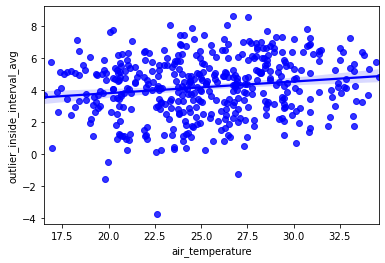

In [28]:
# We see that the two contributors with the largest magnitude appear to be air_temperature (positively correlated) 
# and wind direction (negatively correlated)
sns.regplot(flight_summary['air_temperature'], flight_summary['outlier_inside_interval_avg'],color='blue')
# Since the p-value < 0.05 we validate that there appears to be a statistically significant 
# slight positive correlation between air temp and the magnitude of elevation jumps during the 7.8s-8s mark
# warm temperatures are not necessarily the cause but serve as a slight predictor of larger jumps

X = flight_summary['air_temperature']
Y = flight_summary['outlier_inside_interval_avg']
mask = ~np.isnan(X) & ~np.isnan(Y)

modeloutput = stats.linregress(X[mask],Y[mask])
print(modeloutput)


/Users/connerreinhardt/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


LinregressResult(slope=-0.034916130719847914, intercept=5.628458855103128, rvalue=-0.08681892946826769, pvalue=0.07013324295019044, stderr=0.019231974158919987, intercept_stderr=0.7893185071747246)


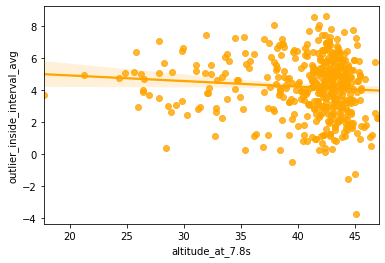

In [29]:
sns.regplot(flight_summary['altitude_at_7.8s'], flight_summary['outlier_inside_interval_avg'], color='orange')
# another slight predictor is the altitude of the plane at 7.8s - we see that lower altitudes may correlate 
# with slightly larger magnitude jumps in elevation data between the 7.8s-8s interval
# However, Since the p-value >0.05, there is no statistically significant correlation between these two variables

X = flight_summary['altitude_at_7.8s']
Y = flight_summary['outlier_inside_interval_avg']
mask = ~np.isnan(X) & ~np.isnan(Y)

modeloutput = stats.linregress(X[mask],Y[mask])
print(modeloutput)

/Users/connerreinhardt/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


LinregressResult(slope=-0.0030676775083105373, intercept=4.065498884940813, rvalue=-0.10320390738313179, pvalue=0.03119859251658366, stderr=0.0014191994900569548, intercept_stderr=0.1103843889710313)


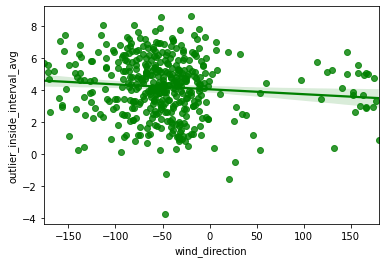

In [30]:
sns.regplot(flight_summary['wind_direction'], flight_summary['outlier_inside_interval_avg'], color='green')
# the last potential predictor of the magnitude of the elevation jumps in the 7.8s-8s interval is the wind direction
# negative (westerly) winds appear to be correlated to higher elevation data jumps
# though again most of the data has negative wind direction, and therefore this may again be a spurulious correlation 
# due to the trailing outliers on the right

X = flight_summary['wind_direction']
Y = flight_summary['outlier_inside_interval_avg']
mask = ~np.isnan(X) & ~np.isnan(Y)

modeloutput = stats.linregress(X[mask],Y[mask])
print(modeloutput)

In [31]:
# Overall, we see that there is a pretty significant sensor error with elevation from our zipline drones
# we understand from this analysis that out of 447 flights, only one of them (flight 17232) has exemplary
# elevation data, and over 436 have major "elevation jumps" between the 7.8s-8s mark, 
# which may indicate a problem with our software or sensory readings.
# There are a couple of weakly correlated factors, though my suggestion to the 
# engineering team is to use flight 17232 as an example and understand what differs between its setup and the other
# 436 flights which exhibited this error. 